In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import pickle
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import plotly.graph_objects as go
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df_demanda = pd.read_csv("..\TESTEO UPDATE\df_demanda_testeo")

In [3]:
df_exchanges = pd.read_csv("..\TESTEO UPDATE\df_exchanges_testeo")

In [4]:
df_generation = pd.read_csv("..\TESTEO UPDATE\df_generation_testeo")

In [5]:
def preprocess_data(df_demanda, df_exchanges, df_generation):
    # Eliminar columnas innecesarias
    df_demanda = df_demanda.drop(columns=["fecha_extraccion"])
    df_exchanges = df_exchanges.drop(columns=["fecha_extraccion"])
    df_generation = df_generation.drop(columns=["fecha_extraccion"])


    # Filtrar y limpiar df_generation
    df_generation_filtered = df_generation[(df_generation['energia'] == 'Generación total') | (df_generation['tipo_tecnología'] == 'Generación total')]
    df_generation_filtered = df_generation_filtered.drop(columns=['energia', 'tipo_tecnología'])
    df_generation_filtered = df_generation_filtered.reset_index(drop=True)

    # Filtrar df_exchanges
    df_exchanges_filtered = df_exchanges[(df_exchanges['tipo_transaccion'] == 'saldo')]
    df_exchanges_agg = df_exchanges_filtered.groupby("fecha", as_index=False)["valor_GW"].sum()

    # Merge de los DataFrames
    df_merge_test = df_demanda.merge(df_exchanges_agg, on="fecha", how="left")
    df_merge_test = df_merge_test.rename(columns={"valor_GW": "saldo_intercambios"})
    df_merge_test = df_merge_test.merge(df_generation_filtered, on="fecha", how="left")
    
    # Interpolación de valores NaN'S en 'saldo_intercambios'
    df_merge_test['saldo_intercambios'] = df_merge_test['saldo_intercambios'].interpolate(method='linear')

    # Crear nuevas columnas basadas en la fecha
    df_merge_test['fecha'] = pd.to_datetime(df_merge_test['fecha'], format='%Y-%m-%d')
    df_merge_test['año'] = df_merge_test['fecha'].dt.year
    df_merge_test['mes'] = df_merge_test['fecha'].dt.month
    df_merge_test['dia'] = df_merge_test['fecha'].dt.day
    df_merge_test['dia_semana'] = df_merge_test['fecha'].dt.weekday
    df_merge_test['es_fin_de_semana'] = df_merge_test['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)
    df_merge_test = df_merge_test.drop(columns=["fecha"])

    return df_merge_test

In [6]:
df=preprocess_data(df_demanda, df_exchanges, df_generation)

In [7]:
df

,valor_demanda_MW,saldo_intercambios,valor_generacion_GW,año,mes,dia,dia_semana,es_fin_de_semana
0,605986.216,-9451.187,627410.852,2011,1,1,5,1
1,641856.087,-25873.160,685838.021,2011,1,2,6,1
2,801297.365,-31853.835,842917.239,2011,1,3,0,0
3,833253.263,-32769.274,871499.828,2011,1,4,1,0
4,803475.573,-23665.904,838808.749,2011,1,5,2,0
...,...,...,...,...,...,...,...,...
5056,643488.948,-19443.509,669626.248,2024,11,4,0,0
5057,669615.970,-19443.509,675211.970,2024,11,5,1,0
5058,670029.342,-19443.509,676725.642,2024,11,6,2,0
5059,672431.939,-19443.509,679811.939,2024,11,7,3,0


In [8]:
def escalador(df, T=7, target_column= 'valor_demanda_MW', scaler_filename="scaler.pkl"):

    columnas_a_escalar = df.drop(columns=[target_column]).columns
    valores = df[columnas_a_escalar].values
    objetivo = df[target_column].values

    # Seleccionar las columnas a escalar, excluyendo la columna objetivo
    valores = valores
    objetivo = objetivo
    
    # Crear y ajustar el escalador
    scaler = StandardScaler()
    valores_escalados = scaler.fit_transform(valores)
    objetivo_escalado = scaler.fit_transform(objetivo.reshape(-1,1))
    
    # Dar forma a los valores escalados
    #valores_escalados = valores_escalados.reshape((valores_escalados.shape[0],valores_escalados.shape[1], 1))
    
    # Guardar el escalador en un archivo pickle
    with open(scaler_filename, "wb") as f:
        pickle.dump(scaler, f)

    # Crear listas para las secuencias de entrada y salida
    X = []
    y = []
    
    # Generar ventanas deslizantes
    for t in range(len(df) - T):
        # Toma valores de X de t en t con stride de 1
        x = valores_escalados[t : t + T]
        X.append(x)
        
        # Toma los valores de t en t
        y_ = objetivo_escalado[t + T]
        y.append(y_)
    
    # Convertir listas a arrays de numpy
    X = np.array(X)  # Dimensión: (samples, timesteps, features)
    y = np.array(y)  # Dimensión: (samples, 1)
    
    return X, y

In [9]:
valores_escalados, objetivo_escalado=escalador(df)

In [10]:
valores_escalados.shape

(5054, 7, 7)

In [11]:
objetivo_escalado.shape

(5054, 1)

In [12]:
def train_test_split_data(valores_escalados, objetivo_escalado, train_ratio=0.8):
    # Calcular el tamaño del conjunto de entrenamiento
    train_size = int(len(valores_escalados) * train_ratio)
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = valores_escalados[:train_size], valores_escalados[train_size:]
    y_train, y_test = objetivo_escalado[:train_size], objetivo_escalado[train_size:]
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test=train_test_split_data(valores_escalados, objetivo_escalado)

In [14]:
def modelo_neuronal_RNN (X_train, y_train, X_test, y_test, T=7, scaler_filename="scaler.pkl", model_filename="rnn_model.pkl"):
    
    # Cargar el escalador preentrenado desde el archivo pickle
    with open(scaler_filename, "rb") as f:
        scaler = pickle.load(f)
    
    # Definición del modelo
    model = Sequential()
    model.add(Input(shape=(T, 7)))
    model.add(SimpleRNN(units=50, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mse")

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # Entrenamiento del modelo
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,callbacks=[early_stopping])
    
    # Realizar predicciones
    predictions_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)
    expected = scaler.inverse_transform(y_test)

    # Guardar el modelo en un archivo pickle
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)

    plt.plot(history.history["val_loss"], label = "val_loss")
    plt.plot(history.history["loss"], label = "loss")
    plt.legend()
    plt.show()
    
    # Mostrar predicciones y graficar resultados
    for i in range(len(y_test)):
        print(f"Real: {expected[i]} | Predicción: {predictions[i]}")

    plt.plot(expected, color="blue", alpha=0.7, label="objetivo")
    plt.plot(predictions, color="green", alpha=0.7, label="prediccion")
    plt.legend()
    plt.show()

    return model, history

Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7218 - val_loss: 0.3394
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1694 - val_loss: 0.2435
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1379 - val_loss: 0.1832
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1272 - val_loss: 0.1737
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1152 - val_loss: 0.1767
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1178 - val_loss: 0.1989
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0935 - val_loss: 0.2148
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0977 - val_loss: 0.1888
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0942 - val_loss: 0.1960
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0932 - val_loss: 0.1636
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0949 - val_loss: 0.1846
Epoch 12/200
127/127 ━━━━━━━━━━━━━━━━━━━━

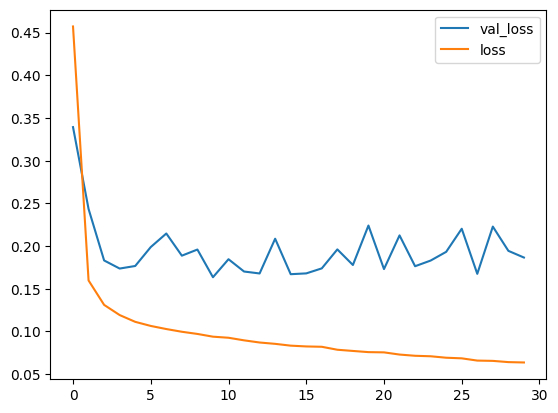

Real: [762494.554] | Predicción: [765874.75]
Real: [760780.897] | Predicción: [776664.3]
Real: [756896.641] | Predicción: [731943.4]
Real: [682674.839] | Predicción: [682718.9]
Real: [635247.08] | Predicción: [643491.2]
Real: [746724.421] | Predicción: [758496.9]
Real: [756678.724] | Predicción: [792024.7]
Real: [755748.252] | Predicción: [773143.6]
Real: [762082.393] | Predicción: [752188.9]
Real: [754633.793] | Predicción: [755549.2]
Real: [679947.691] | Predicción: [689763.3]
Real: [635776.528] | Predicción: [638424.94]
Real: [741719.03] | Predicción: [769736.25]
Real: [759124.039] | Predicción: [776068.]
Real: [758265.98] | Predicción: [766999.25]
Real: [744050.02] | Predicción: [781968.8]
Real: [735427.048] | Predicción: [752622.06]
Real: [677992.558] | Predicción: [656184.]
Real: [628491.111] | Predicción: [655998.7]
Real: [726597.17] | Predicción: [745230.5]
Real: [734120.281] | Predicción: [768094.44]
Real: [732237.567] | Predicción: [729946.4]
Real: [736907.737] | Predicción: 

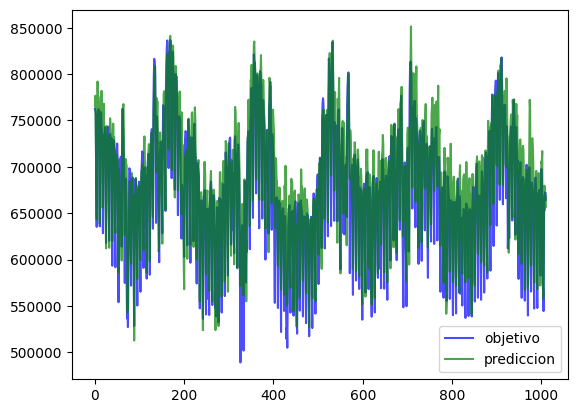

(<Sequential name=sequential, built=True>,
 <keras.src.callbacks.history.History at 0x12a1a49ef10>)

In [15]:
modelo_neuronal_RNN(X_train, y_train, X_test, y_test)

In [16]:
X_test.shape

(1011, 7, 7)

In [17]:
def predict_7_days(scaler_filename="scaler.pkl", model_filename="rnn_model.pkl",last_sequence=X_test):

    with open(scaler_filename, "rb") as f:
        scaler = pickle.load(f)
    
    with open(model_filename, "rb") as f:
        model = pickle.load(f)
    
    #predictions_scaled = []
    #input_sequence = last_sequence.copy()

    #for _ in range(7):  # Predecir 7 días
        # Redimensionar la secuencia para cumplir con el formato del modelo
        #input_sequence_reshaped = input_sequence.reshape(1, input_sequence.shape[0], input_sequence.shape[1])

        # Realizar la predicción
        #prediction_scaled = model.predict(input_sequence_reshaped)[0, 0]  # Extraer el valor escalar
        #predictions_scaled.append(prediction_scaled)

        # Actualizar la secuencia de entrada
        #input_sequence = np.append(input_sequence_reshaped[:,1,:], [[prediction_scaled]], axis=0)
    #predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))
 
    #return predictions
    if last_sequence.ndim == 3:
        last_sequence = last_sequence[0]  

    if last_sequence is None or last_sequence.ndim != 2:
        raise ValueError("`last_sequence` debe ser un array 2D con forma (T, n_features).")
    
    predictions_scaled = []
    input_sequence = last_sequence.reshape(7,7)

    for _ in range(7):  # Predecir 7 días
        # Redimensionar la secuencia para cumplir con el formato del modelo
        input_sequence_reshaped = input_sequence.reshape(1, input_sequence.shape[0], input_sequence.shape[1])

        # Realizar la predicción
        prediction_scaled = model.predict(input_sequence_reshaped)[0, 0]  # Extraer el valor escalar
        predictions_scaled.append(prediction_scaled)

        # Actualizar la secuencia de entrada
        # Desplazar los timesteps anteriores y añadir la nueva predicción como una característica adicional
        new_timestep = np.zeros(input_sequence.shape[1])
        new_timestep[0] = prediction_scaled  # Suponiendo que la predicción corresponde a la primera característica
        input_sequence = np.vstack((input_sequence[1:], new_timestep))
    
    # Invertir la escala de las predicciones
    predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))
    
    return predictions
    

In [18]:
predictions_7 = predict_7_days()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [19]:
predictions_7

array([[765874.75],
       [748136.06],
       [716359.75],
       [655890.  ],
       [650071.  ],
       [676154.06],
       [676645.25]], dtype=float32)

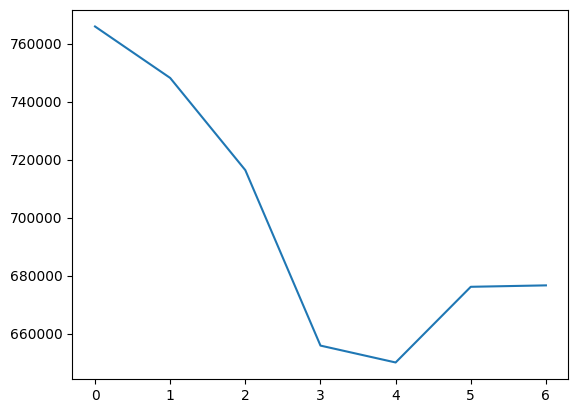

In [20]:
plt.plot(predictions_7)

In [21]:
def modelo_neuronal_lstm (X_train, y_train, X_test, y_test, T=7,scaler_filename="scaler.pkl", model_filename="lstm_model.pkl"):
    # Cargar el escalador preentrenado desde el archivo pickle
    with open(scaler_filename, "rb") as f:
        scaler = pickle.load(f)
    
    # Definición del modelo LSTM
    model_lstm = Sequential()
    model_lstm.add(Input(shape=(T,7)))
    model_lstm.add(LSTM(units=50, activation='relu'))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer="adam", loss="mse")


    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # Entrenamiento del modelo
    history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,callbacks=[early_stopping])
    
    # Realizar predicciones
    predictions_scaled = model_lstm.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)
    expected = scaler.inverse_transform(y_test)

    # Guardar el modelo en un archivo pickle
    with open(model_filename, "wb") as f:
        pickle.dump(model_lstm, f)

    plt.plot(history_lstm.history["val_loss"], label = "val_loss")
    plt.plot(history_lstm.history["loss"], label = "loss")
    plt.legend()
    plt.show()
    
    # Mostrar predicciones y graficar resultados
    for i in range(len(y_test)):
        print(f"Real: {expected[i]} | Predicción: {predictions[i]}")

    plt.plot(expected, color="blue", alpha=0.7, label="objetivo")
    plt.plot(predictions, color="green", alpha=0.7, label="prediccion")
    plt.legend()
    plt.show()

    return model_lstm, history_lstm

Epoch 1/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7727 - val_loss: 0.3072
Epoch 2/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2290 - val_loss: 0.2366
Epoch 3/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1533 - val_loss: 0.1514
Epoch 4/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1303 - val_loss: 0.1888
Epoch 5/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1287 - val_loss: 0.1895
Epoch 6/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1103 - val_loss: 0.1684
Epoch 7/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1091 - val_loss: 0.1466
Epoch 8/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1068 - val_loss: 0.2109
Epoch 9/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1052 - val_loss: 0.1384
Epoch 10/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1047 - val_loss: 0.1554
Epoch 11/200
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0938 - val_loss: 0.1265
Epoch 12/200
127/127 ━━━━━━━━━━━━━━━━━━━━

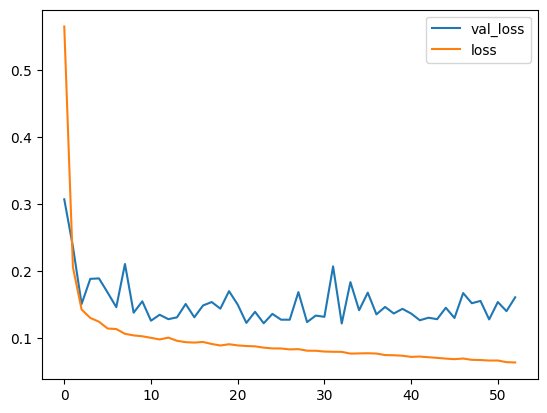

Real: [762494.554] | Predicción: [777699.9]
Real: [760780.897] | Predicción: [770389.5]
Real: [756896.641] | Predicción: [752404.25]
Real: [682674.839] | Predicción: [690234.44]
Real: [635247.08] | Predicción: [641369.1]
Real: [746724.421] | Predicción: [753821.25]
Real: [756678.724] | Predicción: [781562.3]
Real: [755748.252] | Predicción: [776206.6]
Real: [762082.393] | Predicción: [758009.5]
Real: [754633.793] | Predicción: [744218.56]
Real: [679947.691] | Predicción: [678927.3]
Real: [635776.528] | Predicción: [630139.7]
Real: [741719.03] | Predicción: [757458.3]
Real: [759124.039] | Predicción: [771411.]
Real: [758265.98] | Predicción: [759612.5]
Real: [744050.02] | Predicción: [776368.56]
Real: [735427.048] | Predicción: [740758.06]
Real: [677992.558] | Predicción: [668391.]
Real: [628491.111] | Predicción: [648583.4]
Real: [726597.17] | Predicción: [744799.94]
Real: [734120.281] | Predicción: [751682.3]
Real: [732237.567] | Predicción: [735362.75]
Real: [736907.737] | Predicción

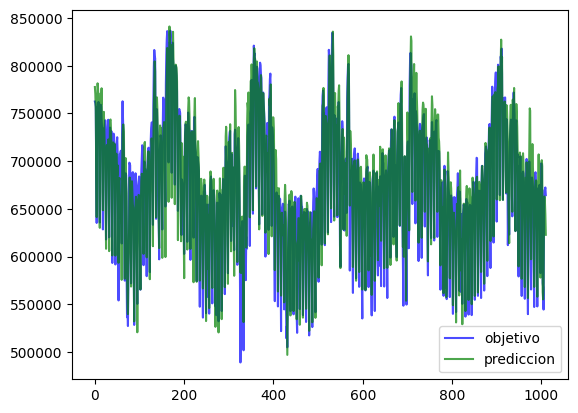

(<Sequential name=sequential_1, built=True>,
 <keras.src.callbacks.history.History at 0x12a1b7aad50>)

In [22]:
modelo_neuronal_lstm(X_train, y_train, X_test, y_test)

In [23]:
predictions_7_lstm = predict_7_days(model_filename="lstm_model.pkl")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [24]:
predictions_7_lstm

array([[777699.9 ],
       [734728.1 ],
       [729249.75],
       [703505.7 ],
       [685204.5 ],
       [706735.2 ],
       [709958.25]], dtype=float32)

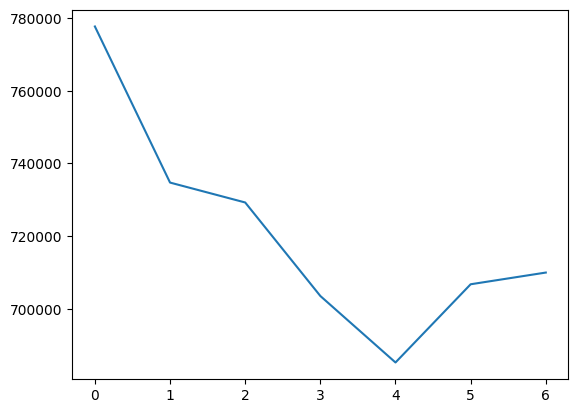

In [25]:
plt.plot(predictions_7_lstm)